LSTM, GRU

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/9-3.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [2]:
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism() # TensorFlow에서 연산 결정론적 실행을 활성화하는 함수

LSTM 신경망 훈련하기

In [3]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500) # 가장 자주 등장하는 단어 500개만 사용

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

17464789/17464789 [==============================] - 1s 0us/step


In [4]:
# 시퀀스 데이터를 패딩하여 일정한 길이로 만드는 작업
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100) # 패딩된 시퀀스의 최대 길이=100. 입력 시퀀스의 길이가 100보다 짧으면 패딩이 추가되어 시퀀스의 길이가 100이 됨
val_seq = pad_sequences(val_input, maxlen=100)

In [5]:
from tensorflow import keras # 딥러닝 모델을 구축하고 학습하기 위해 필요란 모듈을 임포트

model = keras.Sequential() # 각 레이어를 순차적으로 쌓아서 모델을 구축하는 Sequential 모델

model.add(keras.layers.Embedding(500, 16, input_length=100)) # 단어를 고정된 길이의 벡터로 변환해주는 역할을 하는 Embedding 레이어 추가
model.add(keras.layers.LSTM(8)) # LSTM(Long Short-Term Memory) 레이어 추가. LSTM의 유닛 수=8
model.add(keras.layers.Dense(1, activation='sigmoid')) # Fully Connected 레이어 추가

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8809 (34.41 KB)
Trainable params: 8809 (34.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# RMSprop(=경사 하강법의 한 종류로, 학습 속도를 조절하여 모델이 최적의 가중치를 찾도록 도움) 옵티마이저 정의
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy']) # 모델의 성능을 평가할 지표=정확도

# 모델의 가중치를 저장하는 콜백 함수 정의
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5',
                                                save_best_only=True) # 최상의 성능을 보이는 모델만 저장

# 조기 종료를 수행하는 콜백 함수 정의
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, # 성능이 향상되지 않더라도 몇 번까지 더 기다릴 것인지
                                                  restore_best_weights=True) # 조기 종료 후에 최상의 성능을 보이는 모델의 가중치로 복구할 것인지

history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target), # 검증 데이터 지정
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100


313/313 [==============================] - 8s 20ms/step - loss: 0.6927 - accuracy: 0.5277 - val_loss: 0.6924 - val_accuracy: 0.5368
Epoch 2/100
  7/313 [..............................] - ETA: 5s - loss: 0.6923 - accuracy: 0.5670

c:\Users\tjoeun\miniconda3\envs\tensorcpuenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 6s 18ms/step - loss: 0.6916 - accuracy: 0.5677 - val_loss: 0.6911 - val_accuracy: 0.5668
Epoch 3/100
313/313 [==============================] - 6s 18ms/step - loss: 0.6896 - accuracy: 0.6011 - val_loss: 0.6883 - val_accuracy: 0.6062
Epoch 4/100
313/313 [==============================] - 6s 18ms/step - loss: 0.6842 - accuracy: 0.6363 - val_loss: 0.6792 - val_accuracy: 0.6618
Epoch 5/100
313/313 [==============================] - 6s 18ms/step - loss: 0.6589 - accuracy: 0.6827 - val_loss: 0.6277 - val_accuracy: 0.7076
Epoch 6/100
313/313 [==============================] - 6s 18ms/step - loss: 0.6084 - accuracy: 0.7135 - val_loss: 0.5964 - val_accuracy: 0.7114
Epoch 7/100
313/313 [==============================] - 6s 18ms/step - loss: 0.5834 - accuracy: 0.7280 - val_loss: 0.5746 - val_accuracy: 0.7330
Epoch 8/100
313/313 [==============================] - 6s 18ms/step - loss: 0.5617 - accuracy: 0.7452 - val_loss: 0.5553 - val_accuracy: 0.7452
Epoc

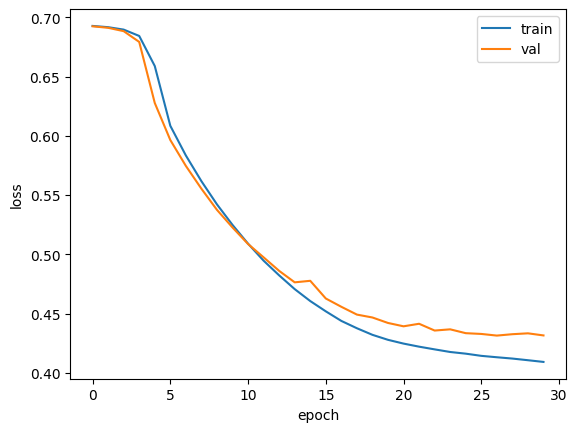

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss']) # 훈련 데이터셋에 대한 손실(오차)의 변화를 나타낸 그래프
plt.plot(history.history['val_loss']) # 검증 데이터셋에 대한 손실(오차)의 변화를 나타낸 그래프
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val']) # 범례
plt.show()

순환층에 드롭아웃 적용하기

In [8]:
model2 = keras.Sequential() # Sequential 모델 생성

# 입력으로 들어온 정수 시퀀스를 고정된 차원의 벡터로 변환하는 Embedding 레이어 추가
# 500개의 단어 -> 16차원의 벡터로 임베딩
model2.add(keras.layers.Embedding(500, 16, input_length=100))

# 순환 신경망(RNN)의 한 종류로, 시퀀스 데이터를 처리하기 위한 LSTM 레이어 추가
# dropout: 학습 과정 중에 무작위로 일부 뉴런을 비활성화하여 과적합을 방지
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [9]:
# RMSprop 옵티마이저 정의. 학습률(learning rate)을 1e-4로 설정
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

# 모델의 가중치를 저장하는 콜백 함수 정의
# ModelCheckpoint: 학습 도중 모델의 성능이 좋아질 때마다 모델을 저장
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5',
                                                save_best_only=True)

# 조기 종료를 수행하는 콜백 함수 정의
# EarlyStopping: 학습이 더 이상 성능이 향상되지 않을 때 학습을 조기 종료
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

# 모델을 학습
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 20ms/step - loss: 0.6924 - accuracy: 0.5317 - val_loss: 0.6917 - val_accuracy: 0.5696
Epoch 2/100
 10/313 [..............................] - ETA: 5s - loss: 0.6922 - accuracy: 0.5297

c:\Users\tjoeun\miniconda3\envs\tensorcpuenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 6s 19ms/step - loss: 0.6907 - accuracy: 0.5788 - val_loss: 0.6897 - val_accuracy: 0.5984
Epoch 3/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6879 - accuracy: 0.6057 - val_loss: 0.6861 - val_accuracy: 0.6232
Epoch 4/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6826 - accuracy: 0.6251 - val_loss: 0.6787 - val_accuracy: 0.6392
Epoch 5/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6674 - accuracy: 0.6511 - val_loss: 0.6529 - val_accuracy: 0.6630
Epoch 6/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6258 - accuracy: 0.6999 - val_loss: 0.6108 - val_accuracy: 0.7108
Epoch 7/100
313/313 [==============================] - 6s 19ms/step - loss: 0.5967 - accuracy: 0.7250 - val_loss: 0.5894 - val_accuracy: 0.7274
Epoch 8/100
313/313 [==============================] - 6s 19ms/step - loss: 0.5771 - accuracy: 0.7402 - val_loss: 0.5723 - val_accuracy: 0.7396
Epoc

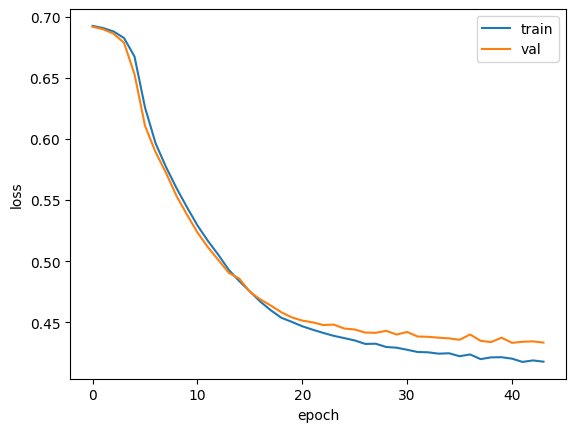

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

2개의 층을 연결하기

In [11]:
# 2개의 LSTM 레이어를 포함한 시퀀스 데이터 처리 모델 정의

model3 = keras.Sequential() # Sequential 모델 생성

model3.add(keras.layers.Embedding(500, 16, input_length=100))

# 첫 번재 LSTM 레이어 추가. return_sequences=True: 이 LSTM 레이어가 시퀀스를 반환해야 함을 나타냄
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))

# 두 번째 LSTM 레이어 추가
model3.add(keras.layers.LSTM(8, dropout=0.3))

# Fully Connected 레이어 추가
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9353 (36.54 KB)
Trainable params: 9353 (36.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 15s 38ms/step - loss: 0.6929 - accuracy: 0.5168 - val_loss: 0.6927 - val_accuracy: 0.5280
Epoch 2/100
313/313 [==============================] - 11s 36ms/step - loss: 0.6914 - accuracy: 0.5788 - val_loss: 0.6893 - val_accuracy: 0.6228
Epoch 3/100
313/313 [==============================] - 11s 36ms/step - loss: 0.6750 - accuracy: 0.6473 - val_loss: 0.6432 - val_accuracy: 0.6782
Epoch 4/100
313/313 [==============================] - 11s 35ms/step - loss: 0.6067 - accuracy: 0.6889 - val_loss: 0.5798 - val_accuracy: 0.7046
Epoch 5/100
313/313 [==============================] - 11s 36ms/step - loss: 0.5611 - accuracy: 0.7233 - val_loss: 0.5406 - val_accuracy: 0.7358
Epoch 6/100
313/313 [==============================] - 11s 36ms/step - loss: 0.5311 - accuracy: 0.7439 - val_loss: 0.5173 - val_accuracy: 0.7542
Epoch 7/100
313/313 [==============================] - 11s 35ms/step - loss: 0.5142 - accuracy: 0.7568 - val_loss: 0.5006 - val_ac

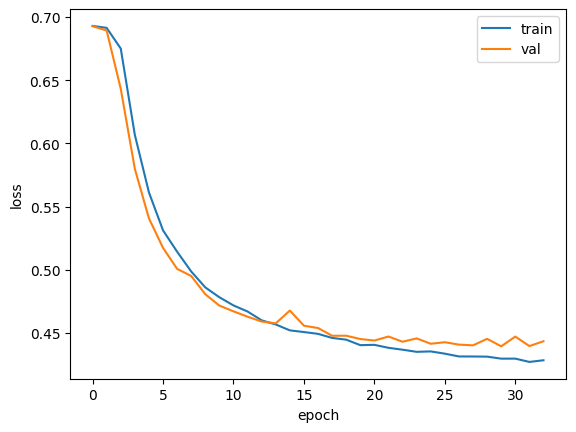

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

GRU 신경망 훈련하기

In [14]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_length=100))

# GRU(Gated Recurrent Unit) 레이어 추가
# GRU: LSTM의 간소화 버전으로, 순환 신경망(RNN)에서 시퀀스 데이터를 처리하는 데 사용
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8633 (33.72 KB)
Trainable params: 8633 (33.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4) # RMSprop: 경사 하강법의 한 종류로, 각 가중치의 학습률을 조절하여 학습의 안정성을 향상시키는 방법
model4.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

# 학습 도중에는 앞서 정의한 콜백 함수들을 사용하여 모델의 성능을 모니터링하고, 필요한 경우 모델의 가중치를 저장하거나 조기 종료를 수행

Epoch 1/100
313/313 [==============================] - 9s 22ms/step - loss: 0.6920 - accuracy: 0.5486 - val_loss: 0.6912 - val_accuracy: 0.5724
Epoch 2/100
313/313 [==============================] - 7s 21ms/step - loss: 0.6898 - accuracy: 0.5790 - val_loss: 0.6889 - val_accuracy: 0.5830
Epoch 3/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6865 - accuracy: 0.5975 - val_loss: 0.6852 - val_accuracy: 0.5958
Epoch 4/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6813 - accuracy: 0.6107 - val_loss: 0.6792 - val_accuracy: 0.5994
Epoch 5/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6732 - accuracy: 0.6204 - val_loss: 0.6701 - val_accuracy: 0.6134
Epoch 6/100
313/313 [==============================] - 7s 21ms/step - loss: 0.6608 - accuracy: 0.6387 - val_loss: 0.6556 - val_accuracy: 0.6302
Epoch 7/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6404 - accuracy: 0.6581 - val_loss: 0.6304 - val_accuracy:

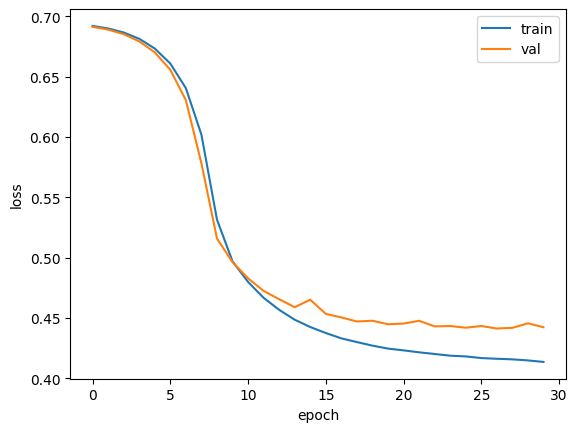

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

마무리

In [17]:
# 테스트 데이터(test_input)를 패딩하여 길이를 맞춤 (모델이 고정된 길이의 입력을 요구하므로)
# 'pad_sequence' 함수를 사용하여 시퀀시의 길이를 100으로 맞추고, 부족한 부분은 0으로 채움
test_seq = pad_sequences(test_input, maxlen=100)

rnn_model = keras.models.load_model('best-2rnn-model.h5')

rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 7s 8ms/step - loss: 0.4346 - accuracy: 0.7975


[0.434622585773468, 0.7974799871444702]